In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

matplotlib.rcParams.update({'font.size': 12})
#matplotlib.rcParams.update({'lines.markersize': 20})

np.random.seed(0)

import Preprocessor
import Parameters
import HHMM
import Visualisor

In [31]:
model = 'CarHHMM2'

In [33]:
pars = Parameters.Parameters()

pars.cvc_file = '../Data/2020/20200822-170001-Gikumi_CC_130.cvc'
pars.csv_file = '../Data/2020/20200822-170001-Gikumi_CC_130_001.csv'

pars.stime = '2020-08-22 08:15:00'
pars.etime = '2020-08-22 15:45:00'
pars.drop_times = []


pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'Ax':{'corr':True,'f':'normal'},
                  'Ay':{'corr':True,'f':'normal'},
                  'Az':{'corr':True,'f':'normal'},
                  'Ahat_low':{'thresh':5,'corr':False,'f':'gamma'}}]

pars.K = [2,3]
if model == 'CarHMM':
    pars.K = [1,3]
elif model == 'HHMM':
    pars.features[1]['Ax']['corr'] = False
    pars.features[1]['Ay']['corr'] = False
    pars.features[1]['Az']['corr'] = False
elif model == 'CarHHMM1':
    pars.features[1] = {'Ax':{'corr':True,'f':'normal'},
                        'Ay':{'corr':True,'f':'normal'},
                        'Az':{'corr':True,'f':'normal'}}

prep = Preprocessor.Preprocessor(pars)

s_dive = 0
e_dive = 266
pars.share_fine_states = True
HHMM_file = '../../Params/data/%s_k_%s_%s_dives_same_fine_states_long' % (model,pars.K[0],pars.K[1])
#HHMM_file = '../Params/Data_%s_k_%s_%s_dives_same_fine_states' % (model,pars.K[0],pars.K[1])
print(HHMM_file)

../../Params/data/CarHHMM2_k_2_3_dives_same_fine_states_long


In [34]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

In [35]:
df.columns

Index(['date', 'time', 'GPS lat', 'GPS long', 'GPS alt', 'GPS speed', 'quats0',
       'quats1', 'quats2', 'quats3', 'acc x', 'acc y', 'acc z', 'gyro x',
       'gyro y', 'gyro z', 'mag x', 'mag y', 'mag z', 'Mx', 'My', 'Mz', 'Ax',
       'Ay', 'Az', 'press', 'pitot speed', 'GPS num sat', 'roll', 'pitch',
       'yaw', 'Date (UTC)', 'Time (UTC)', ' Date (local)', ' Time (local)',
       'Accelerometer X [m/s²]', 'Accelerometer Y [m/s²]',
       'Accelerometer Z [m/s²]', 'Gyroscope X [mrad/s]',
       'Gyroscope Y [mrad/s]', 'Gyroscope Z [mrad/s]', 'Magnetometer X [µT]',
       'Magnetometer Y [µT]', 'Magnetometer Z [µT]', 'Temp. (magnet.) [°C]',
       'depth', 'temp', 'Light intensity 1 [raw]', 'Light intensity 2 [raw]',
       'System error', 'BATT [V]', 'BATT [mA]', 'BATT [mAh]', 'Camera',
       'Flags', 'LED', 'Camera time', 'CC status', ' CC vid. size [kBytes]'],
      dtype='object')

<AxesSubplot:xlabel='time'>

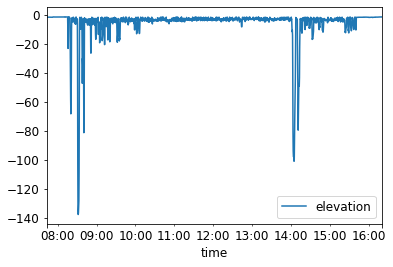

In [46]:
df['elevation'] = -df['depth']
col = 'elevation'
df[['time',col]].iloc[::1000].plot('time',col)

date
time


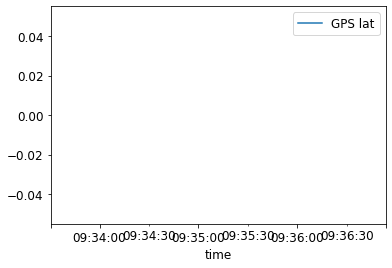

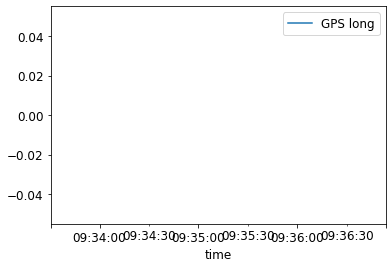

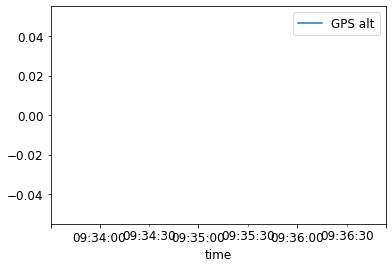

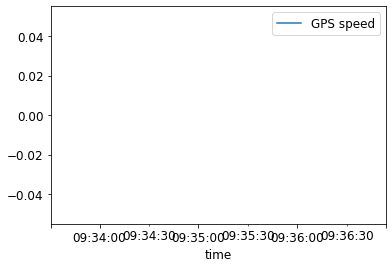

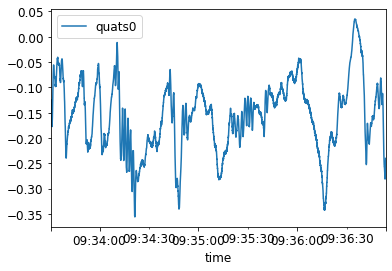

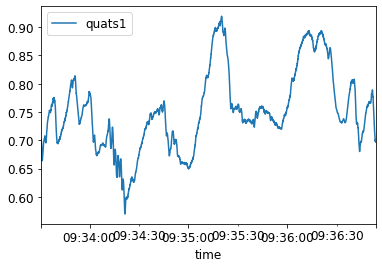

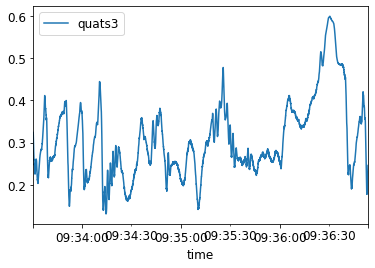

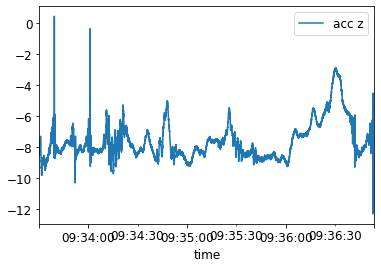

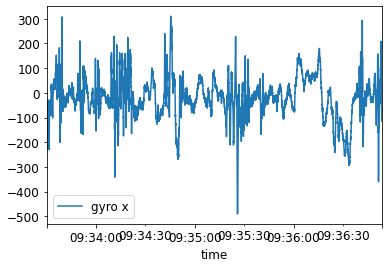

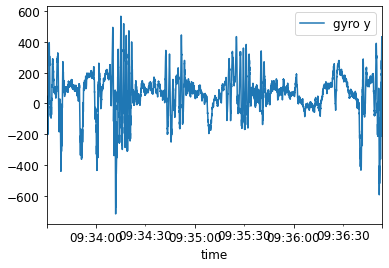

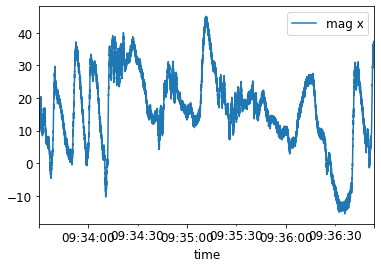

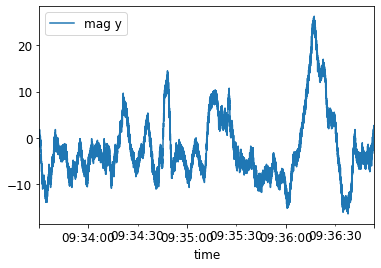

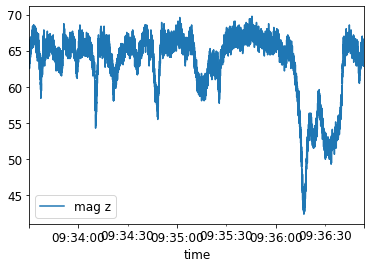

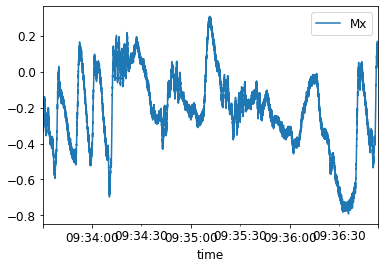

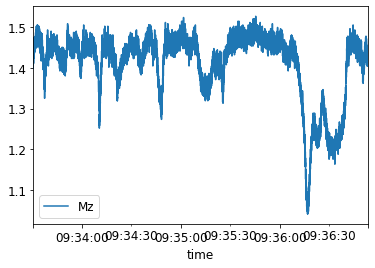

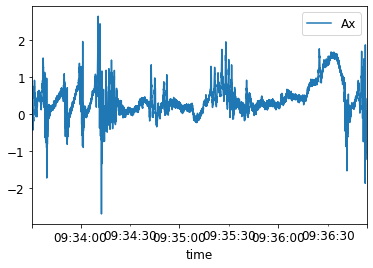

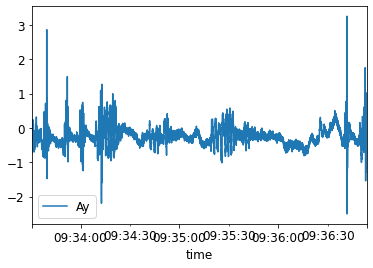

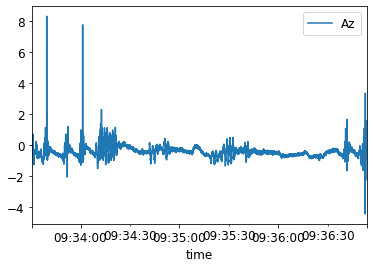

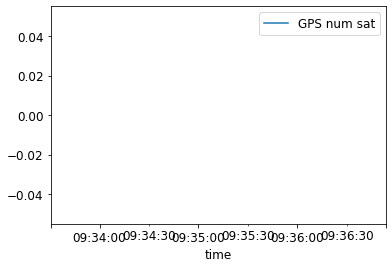

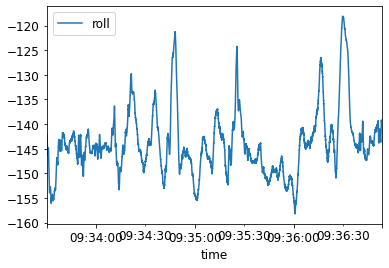

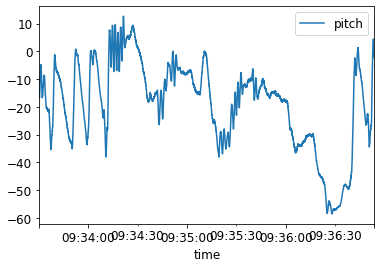

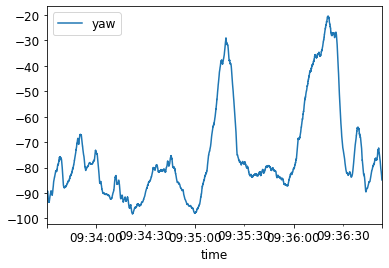

Date (UTC)
Time (UTC)
 Date (local)
 Time (local)


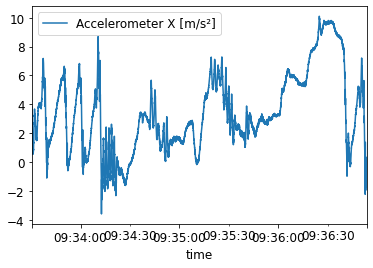

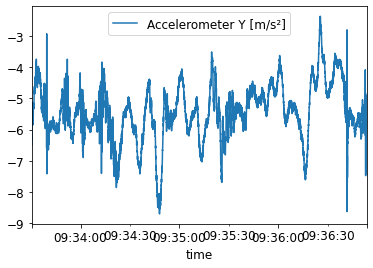

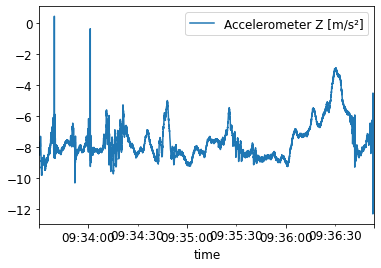

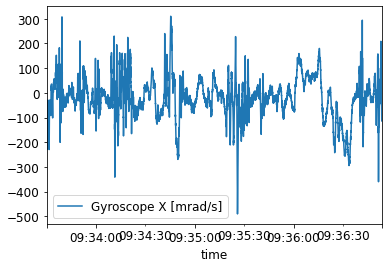

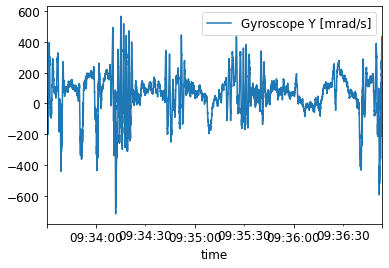

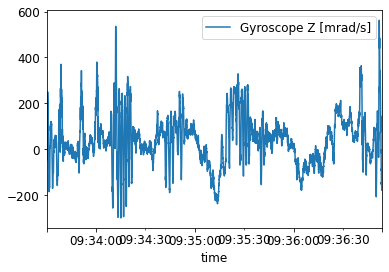

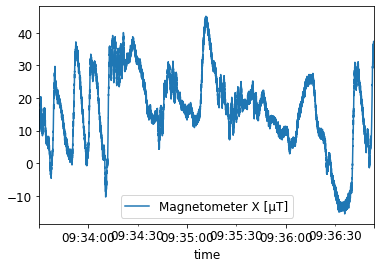

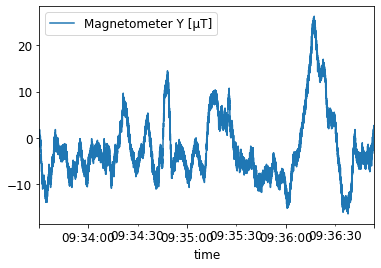

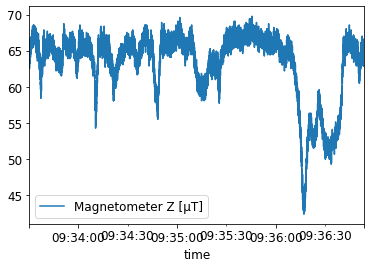

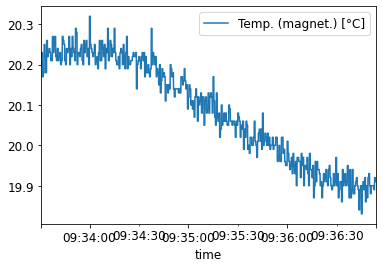

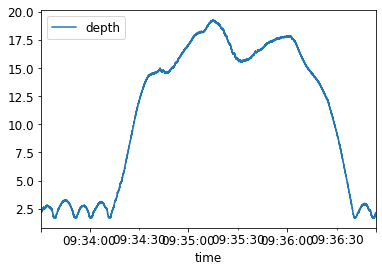

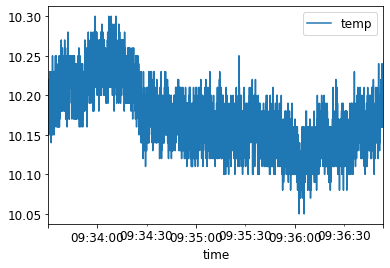

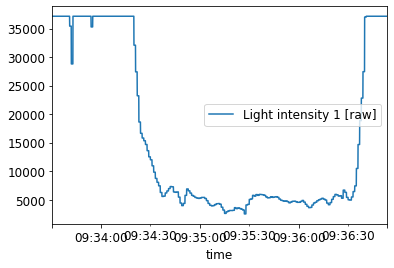

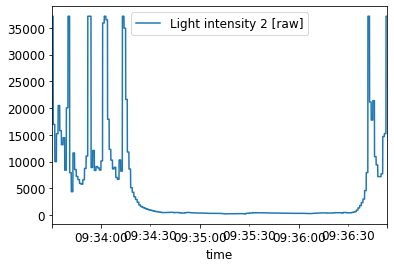

System error


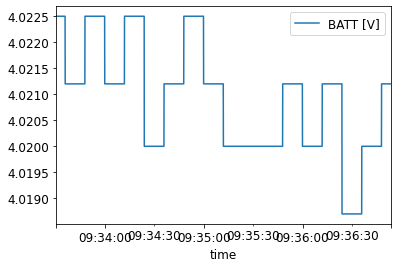

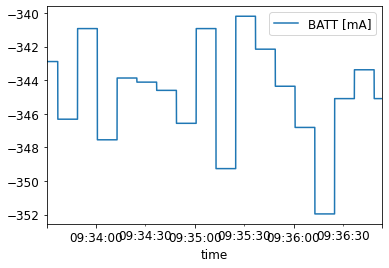

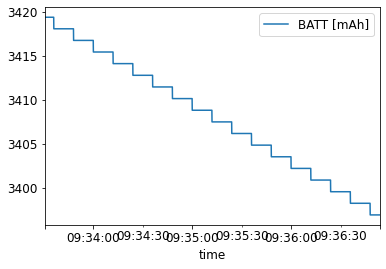

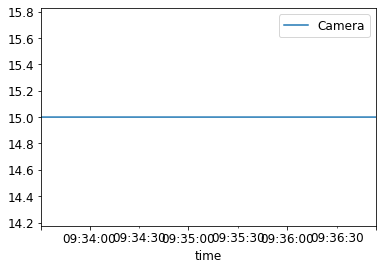

Flags


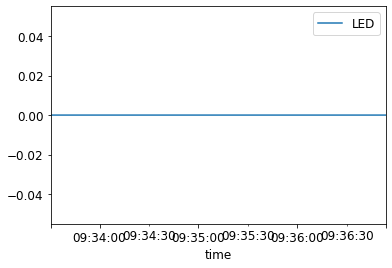

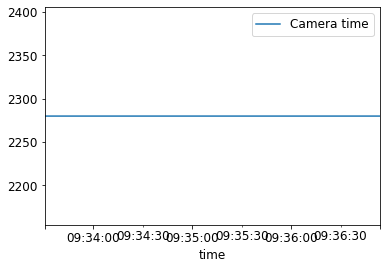

CC status


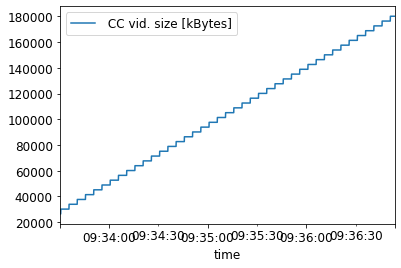

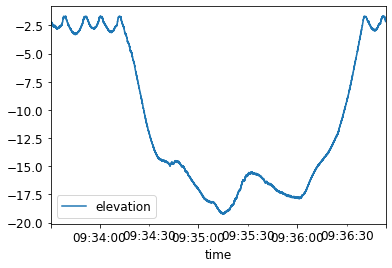

In [54]:
#sind = 0
#eind = 10000000

df_temp = df[(df['time'] > '2020-08-22 09:33:30.420') & \
             (df['time'] < '2020-08-22 09:36:53.640')]

df_temp['elevation'] = -df_temp['depth']

for col in df.columns:
    
    try:
        df_temp[['time',col]].plot('time',col)
        plt.show()
    except:
        print(col)

date
time


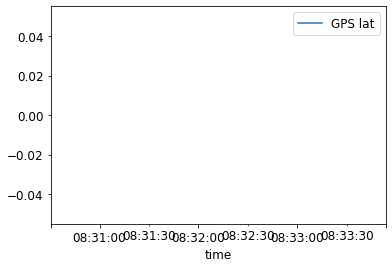

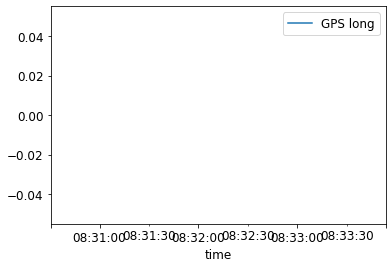

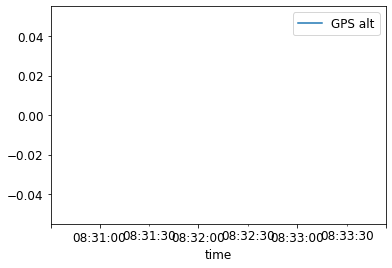

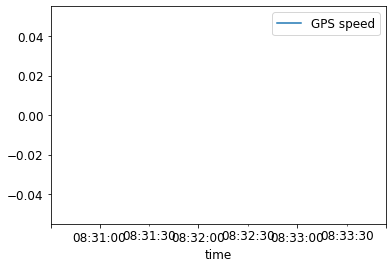

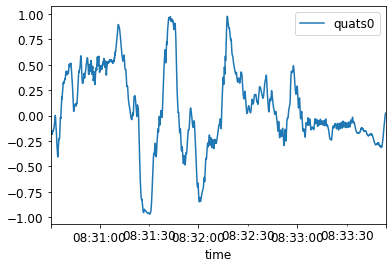

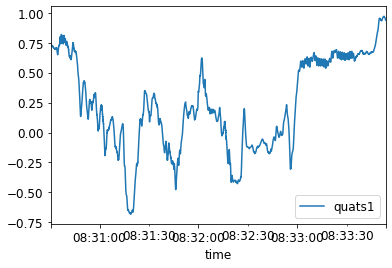

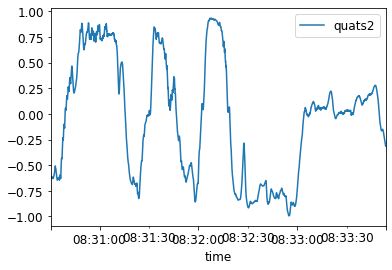

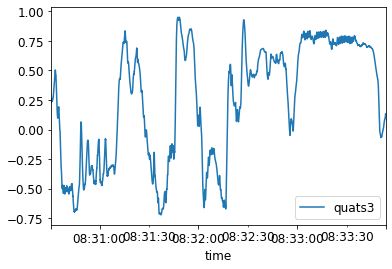

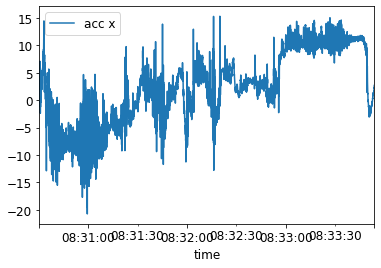

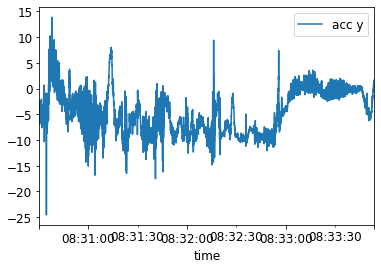

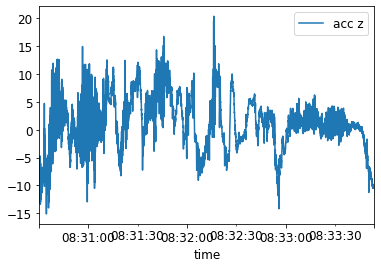

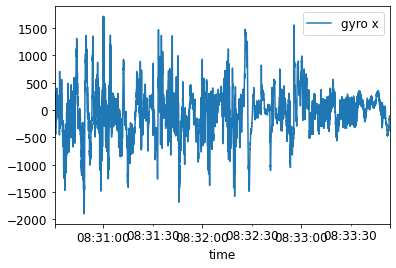

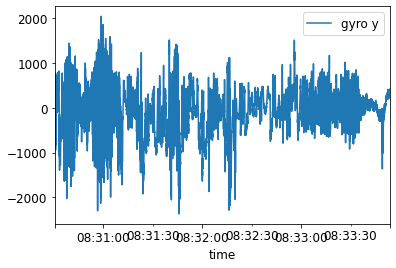

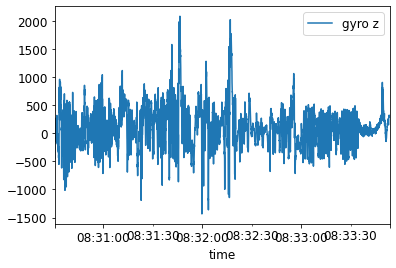

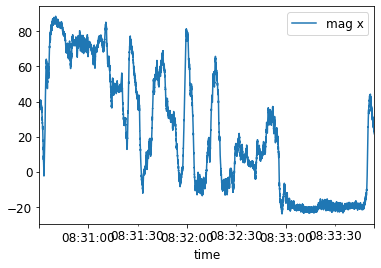

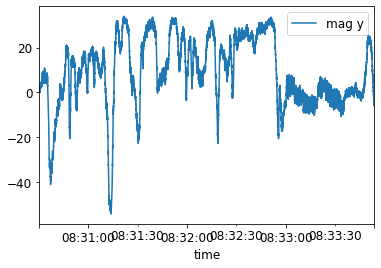

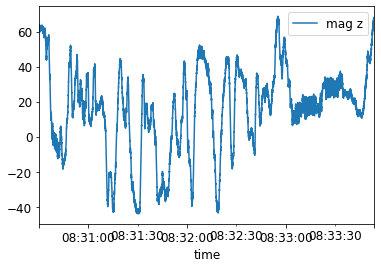

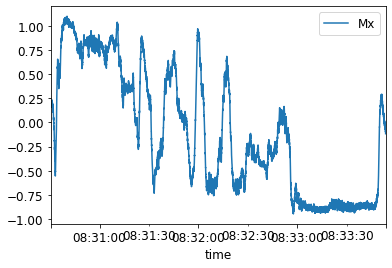

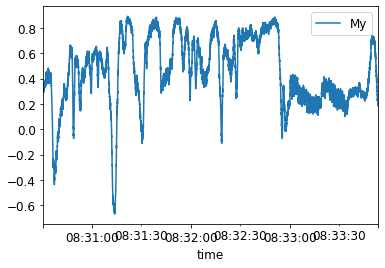

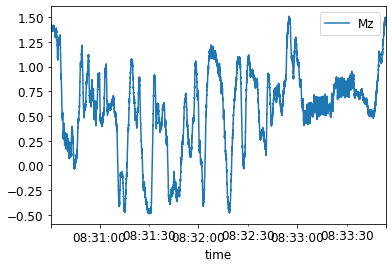

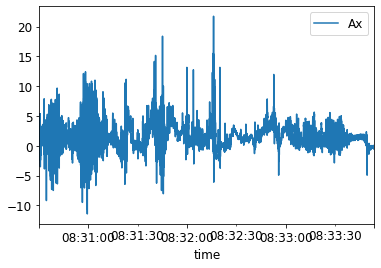

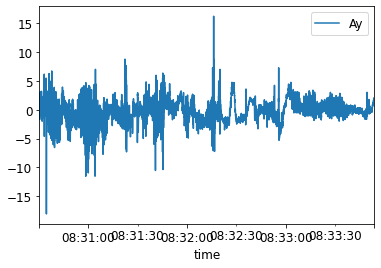

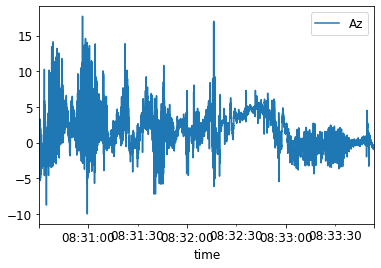

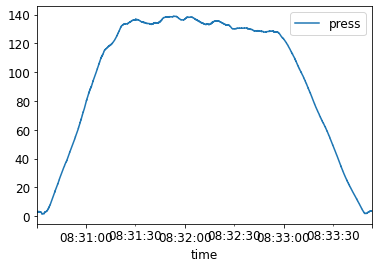

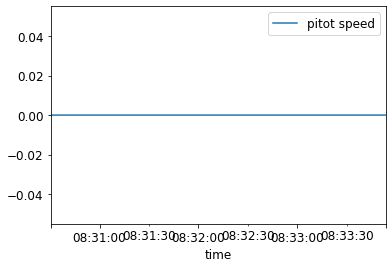

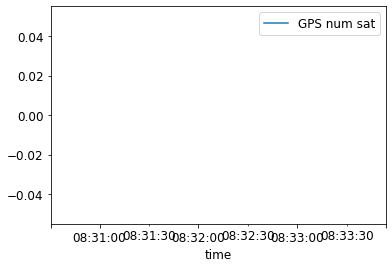

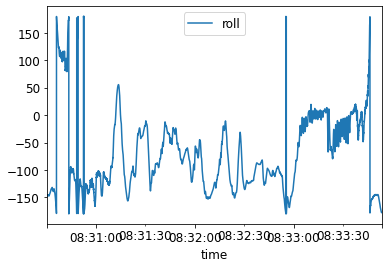

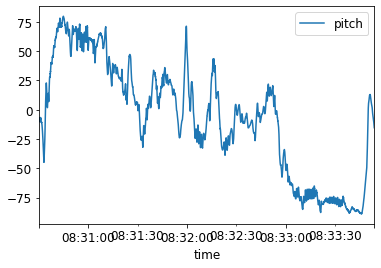

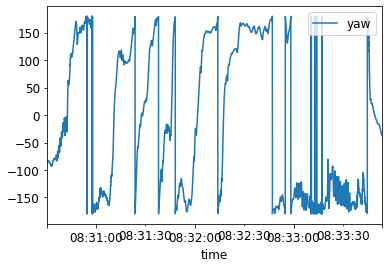

Date (UTC)
Time (UTC)
 Date (local)
 Time (local)


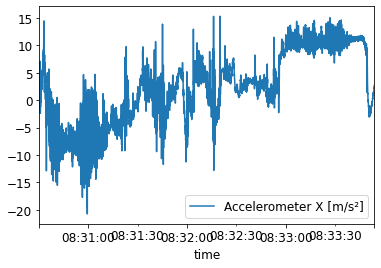

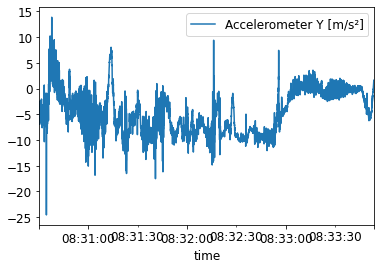

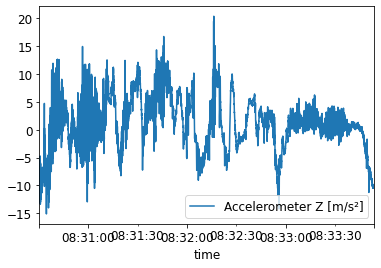

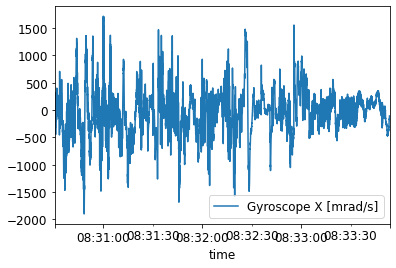

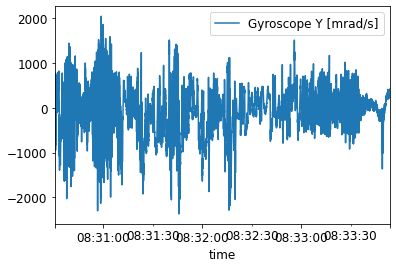

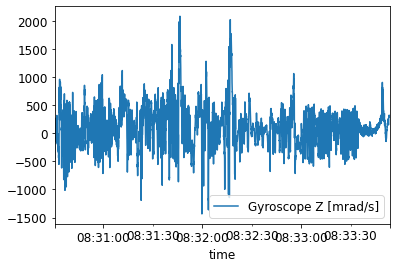

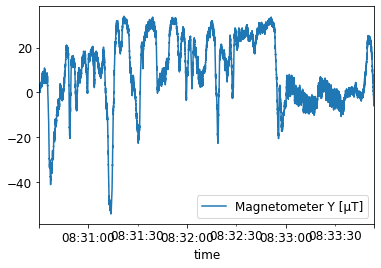

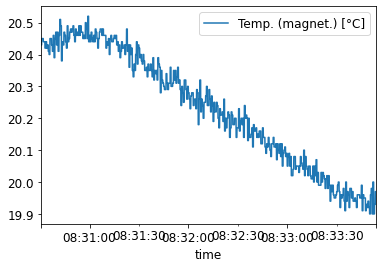

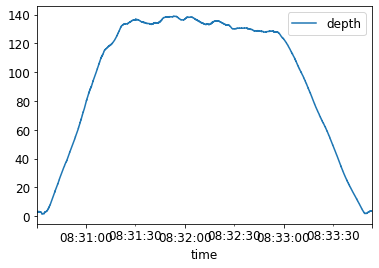

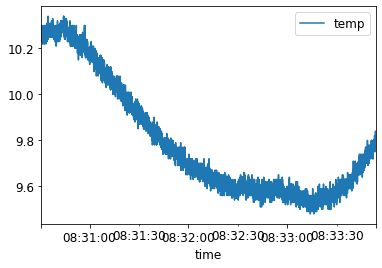

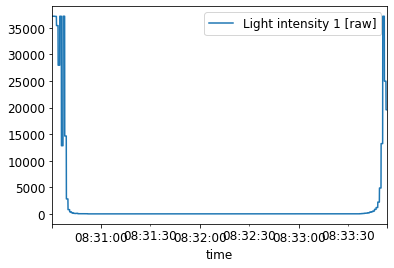

System error


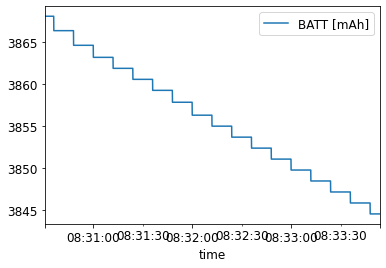

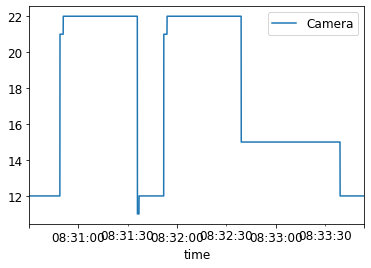

Flags


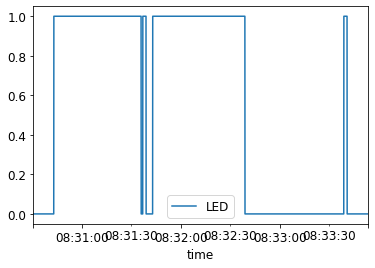

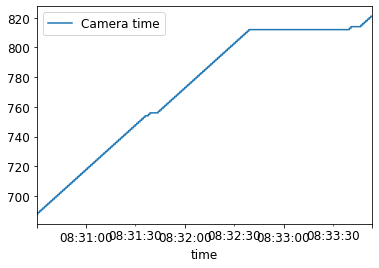

CC status


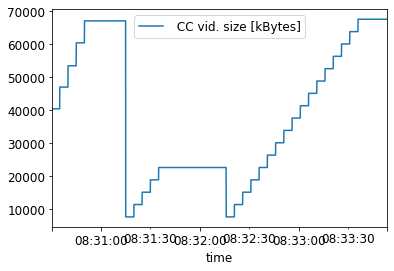

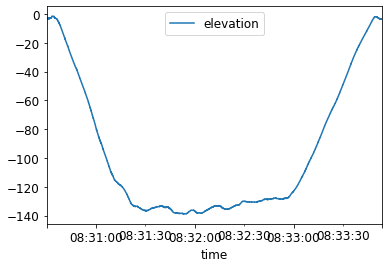

In [53]:
df_temp = df[(df['time'] > '2020-08-22 08:30:30.420') & \
             (df['time'] < '2020-08-22 08:33:53.640')]

df_temp['elevation'] = -df_temp['depth']

for col in df.columns:
    
    try:
        df_temp[['time',col]].plot('time',col)
        plt.show()
    except:
        print(col)

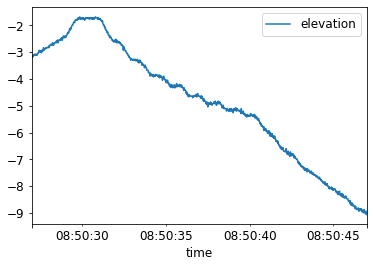

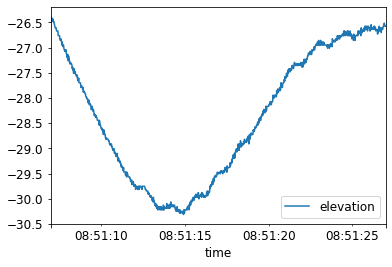

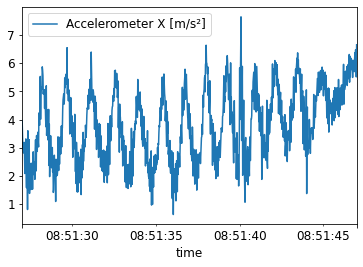

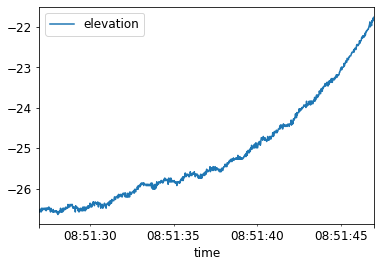

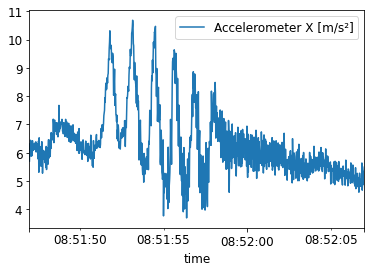

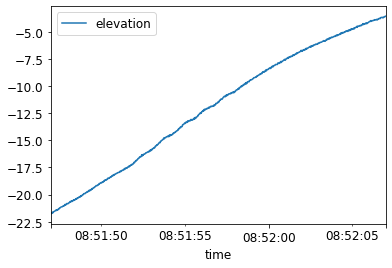

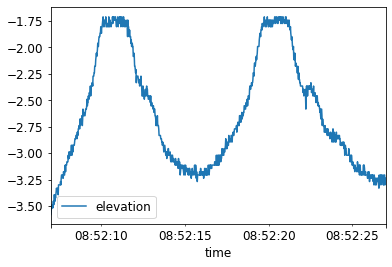

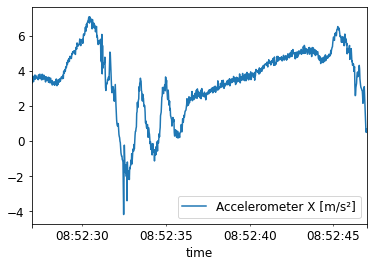

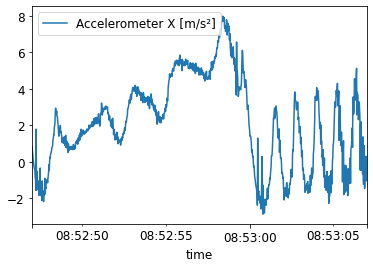

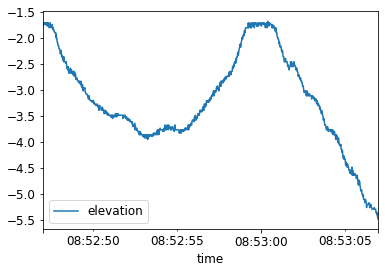

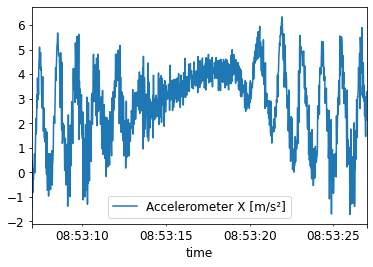

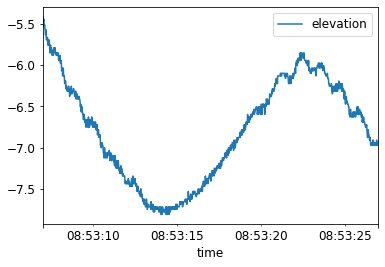

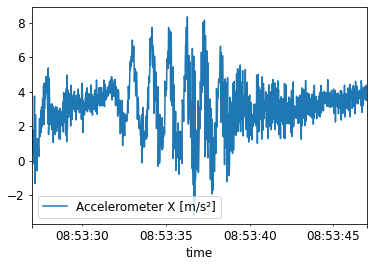

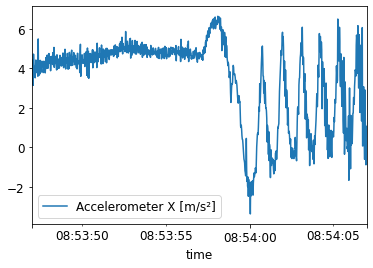

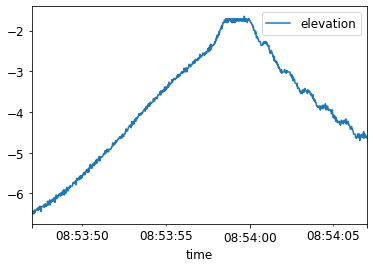

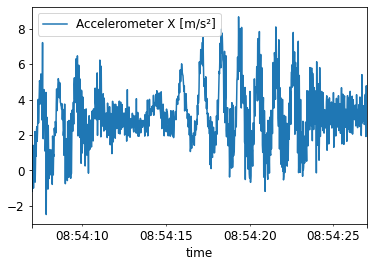

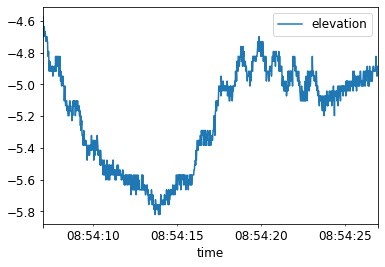

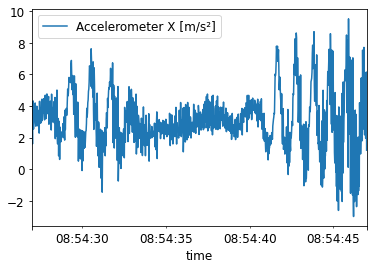

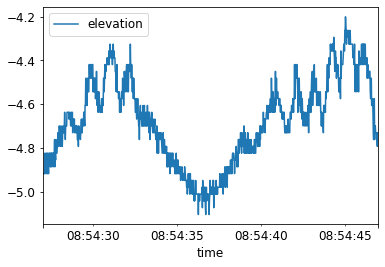

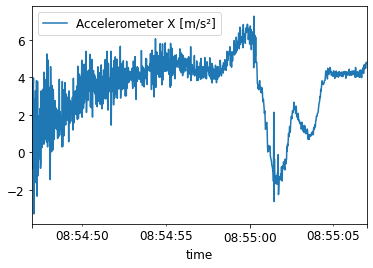

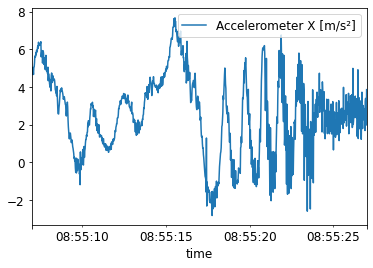

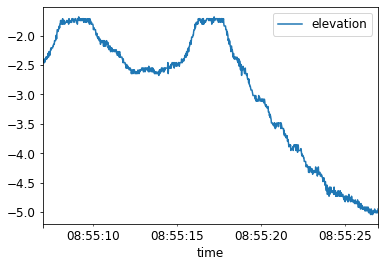

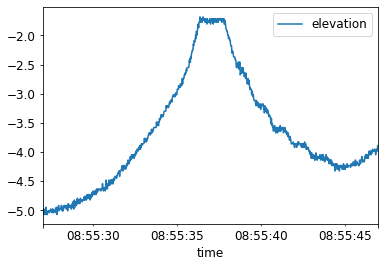

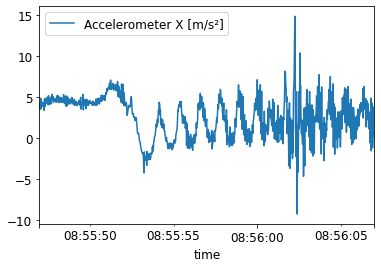

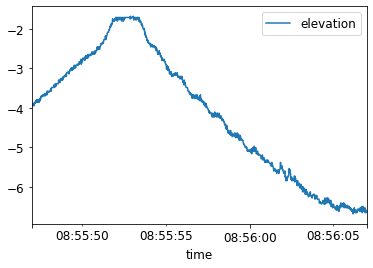

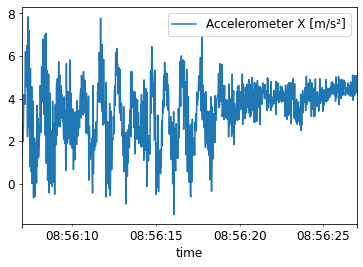

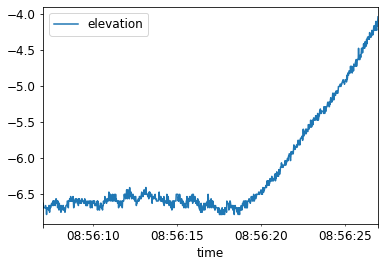

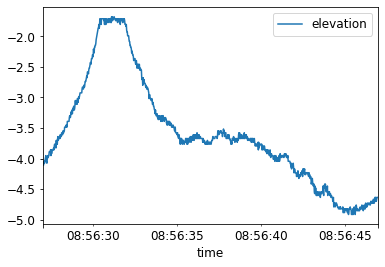

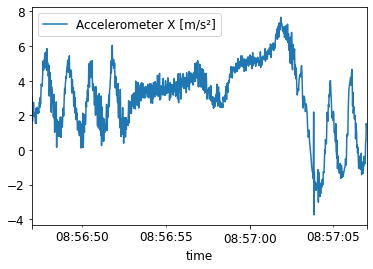

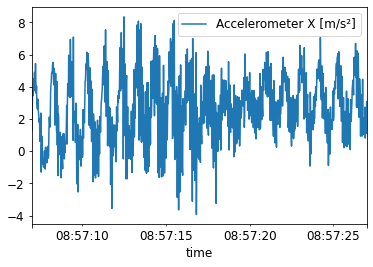

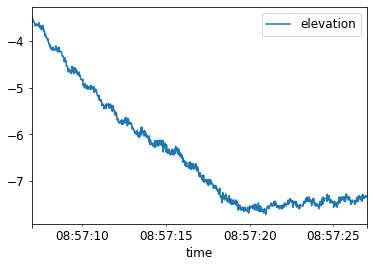

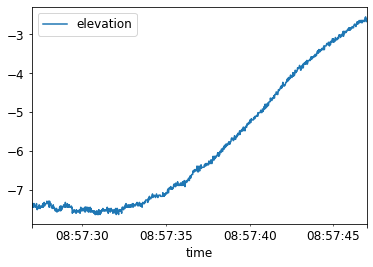

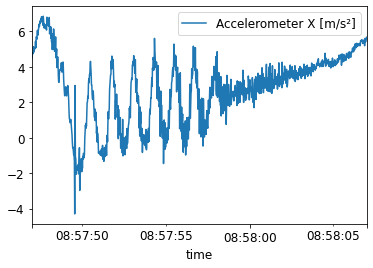

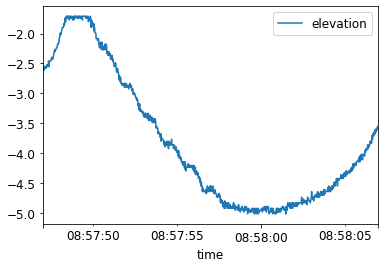

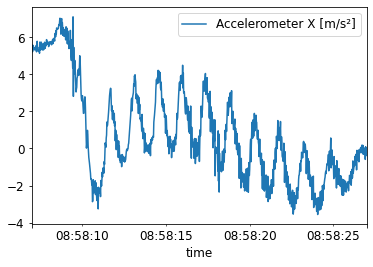

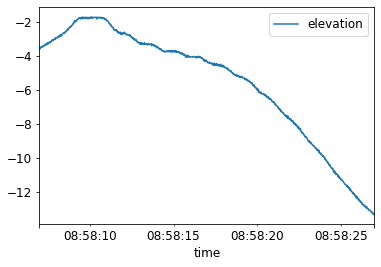

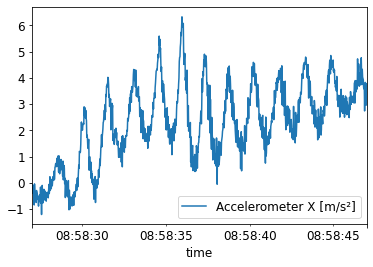

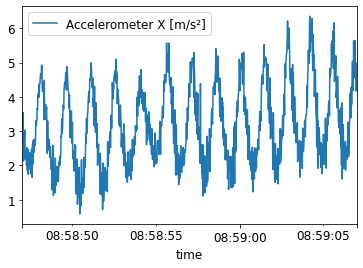

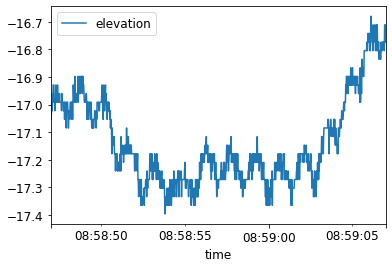

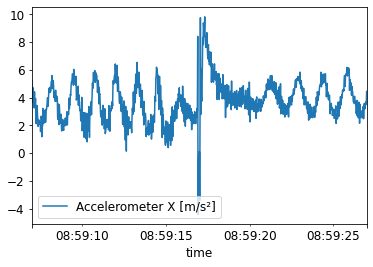

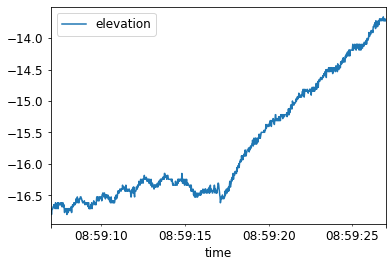

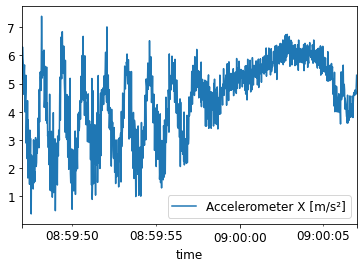

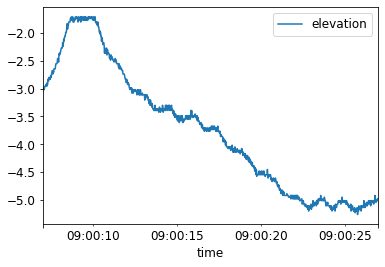

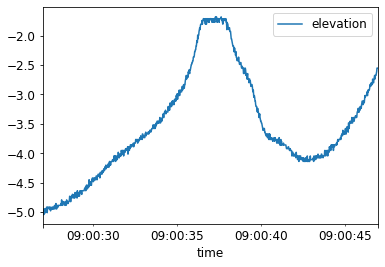

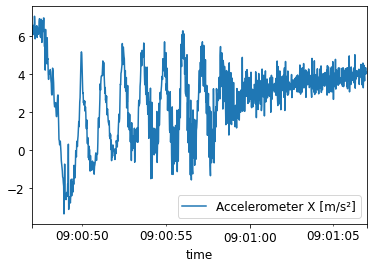

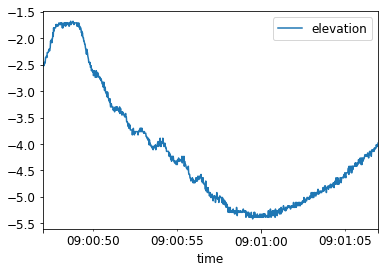

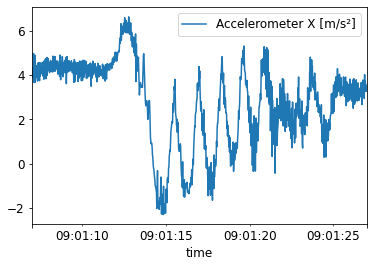

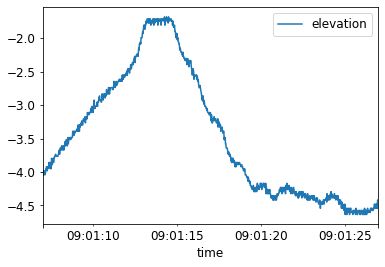

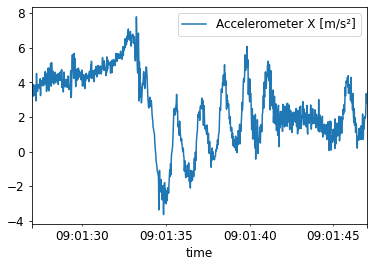

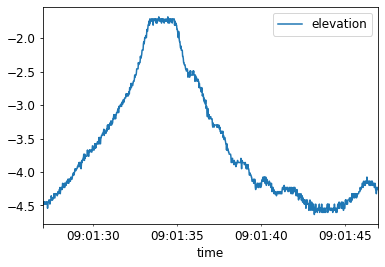

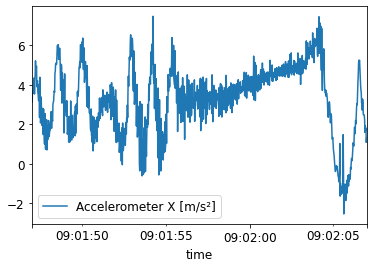

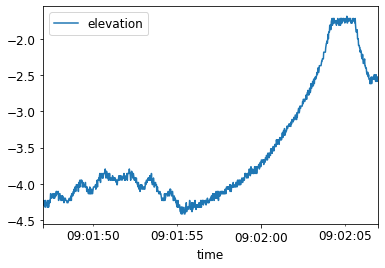

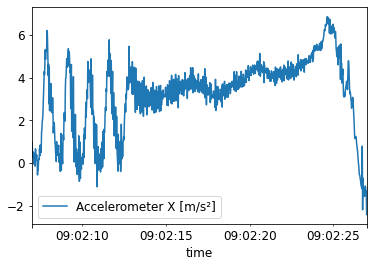

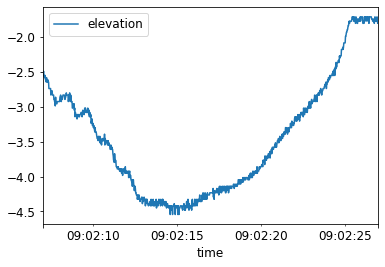

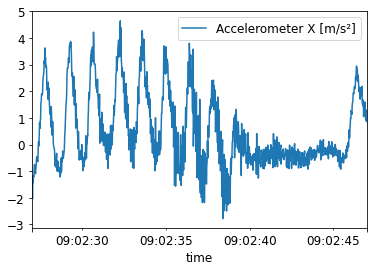

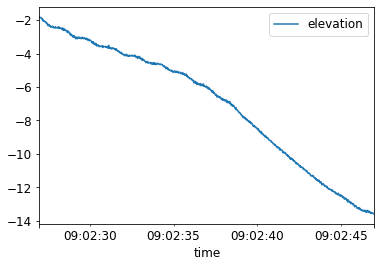

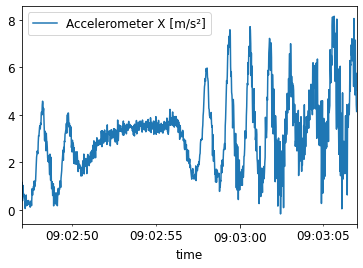

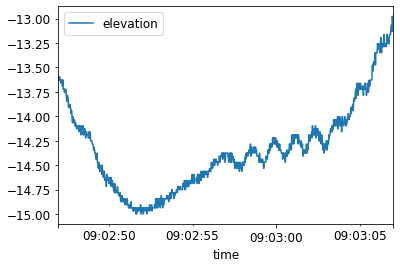

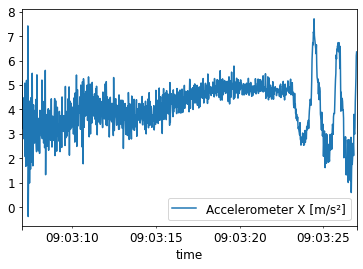

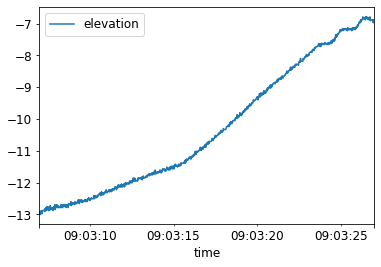

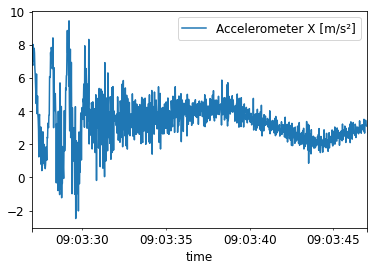

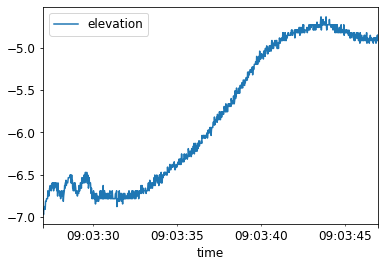

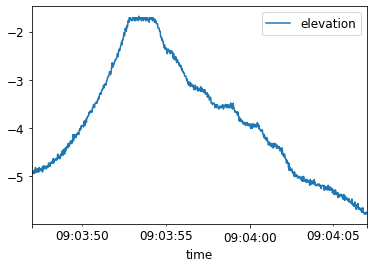

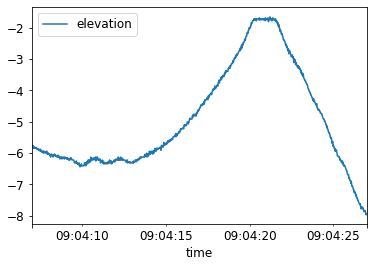

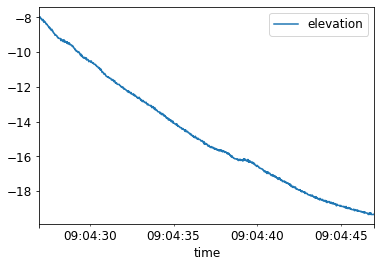

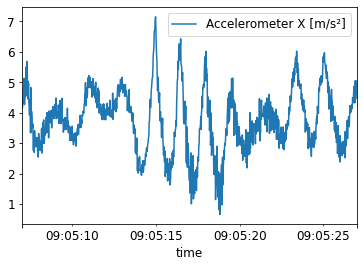

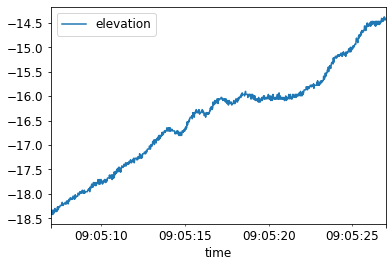

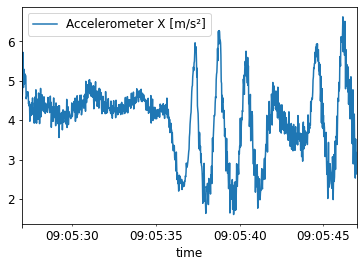

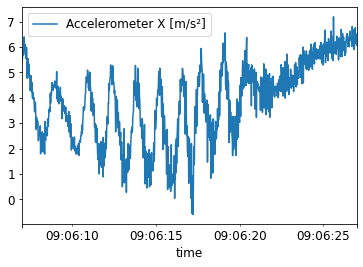

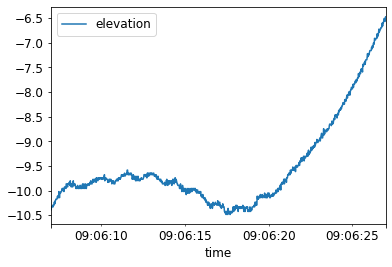

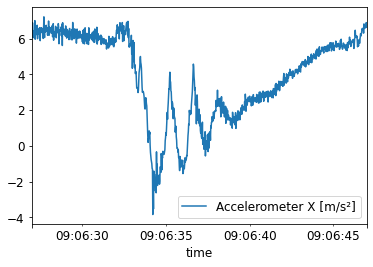

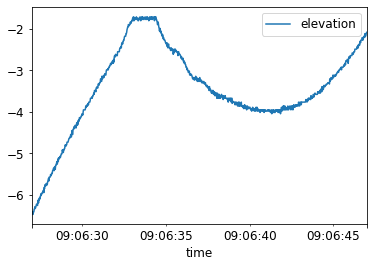

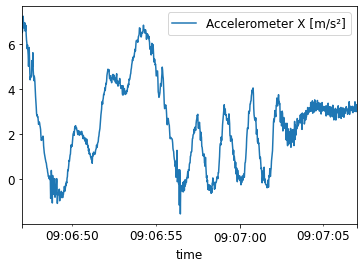

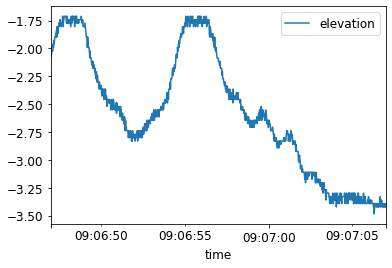

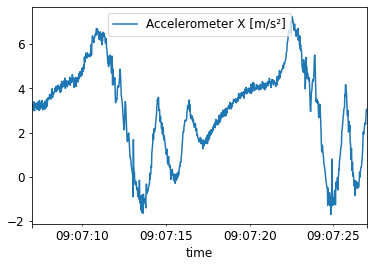

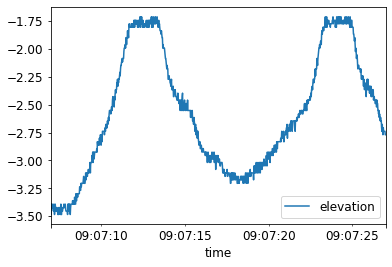

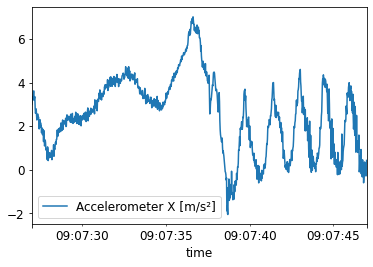

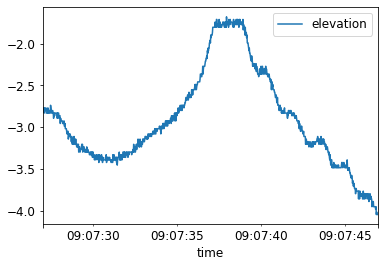

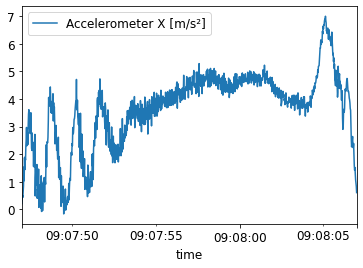

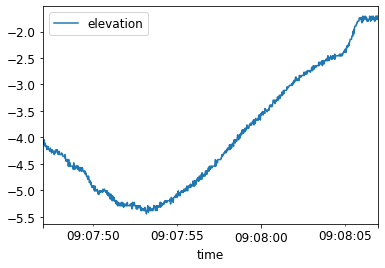

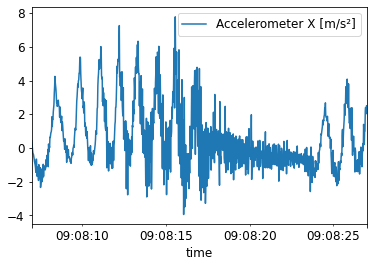

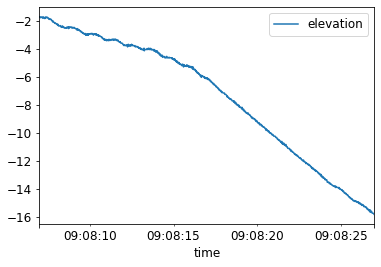

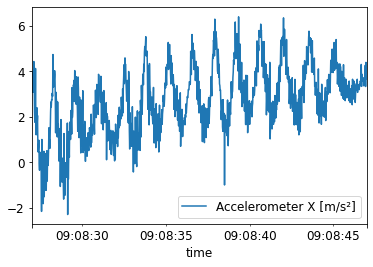

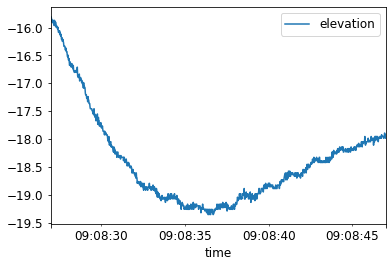

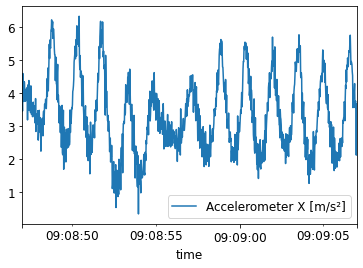

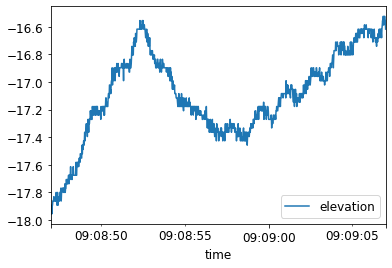

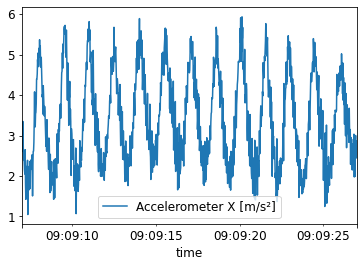

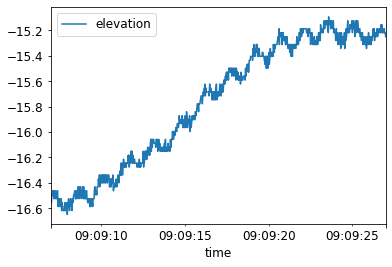

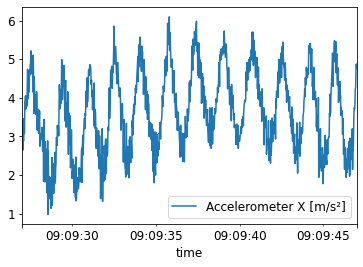

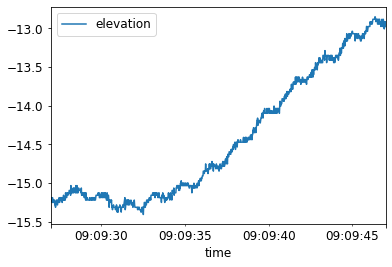

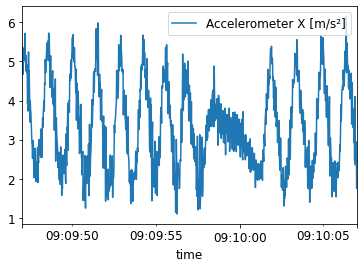

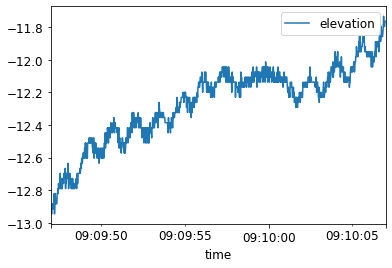

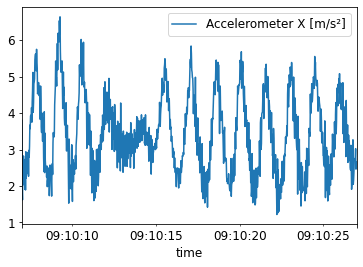

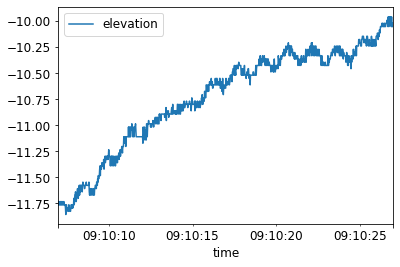

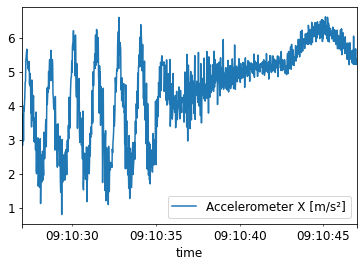

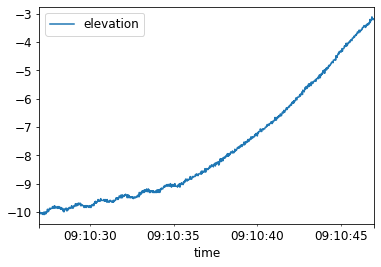

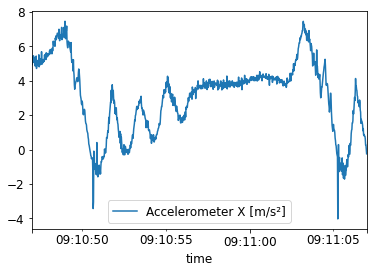

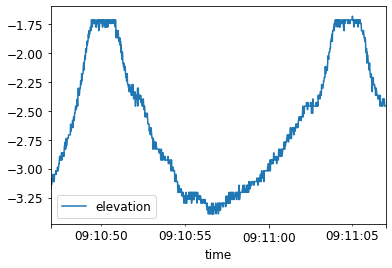

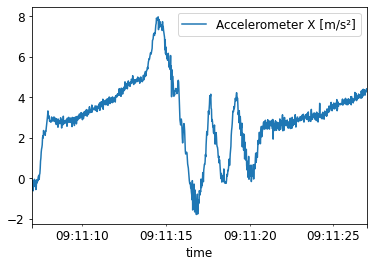

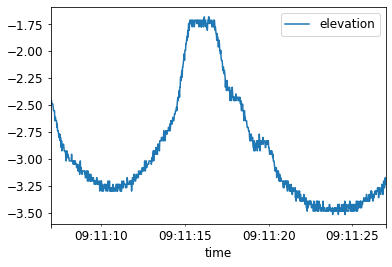

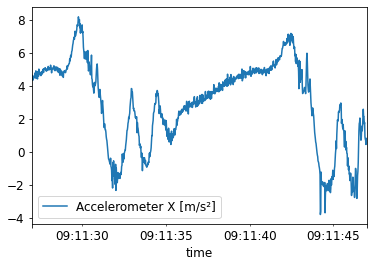

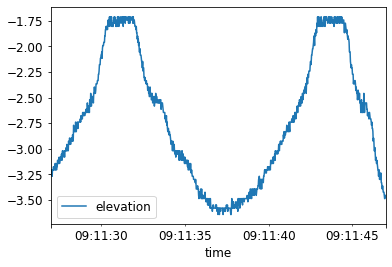

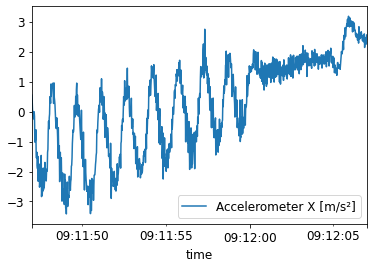

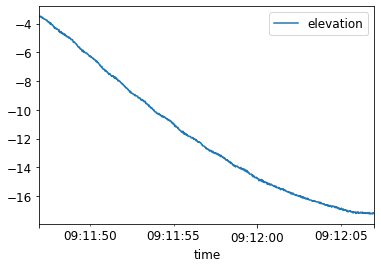

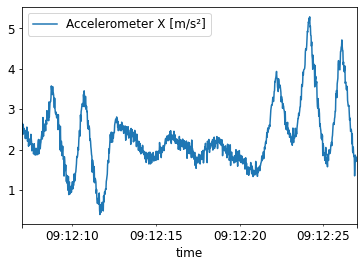

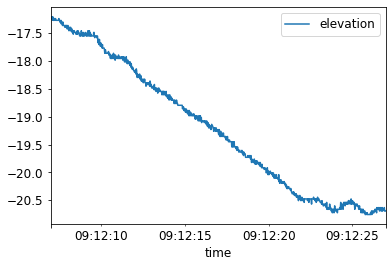

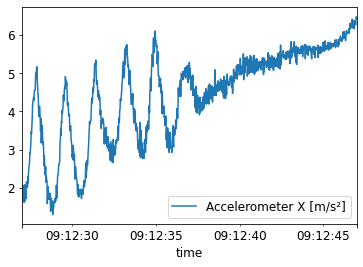

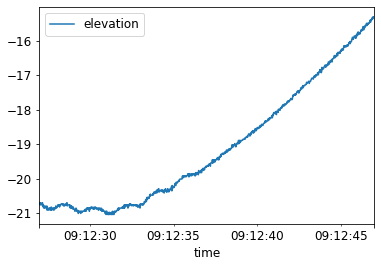

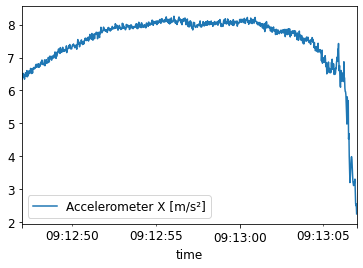

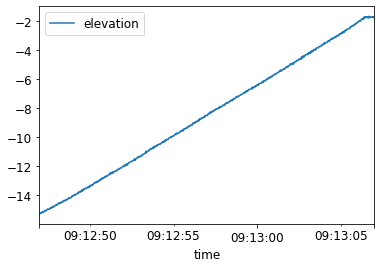

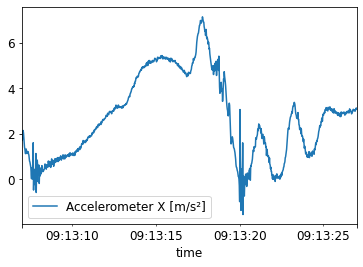

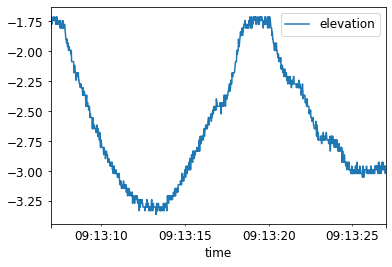

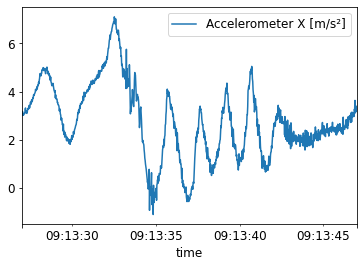

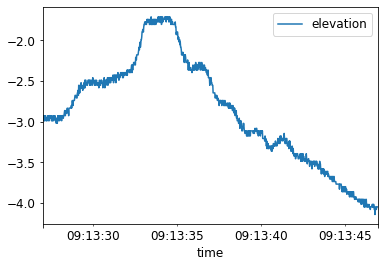

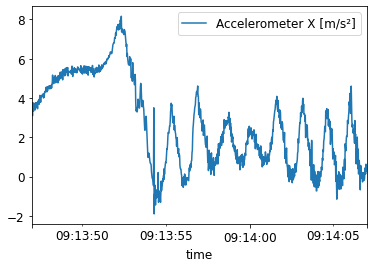

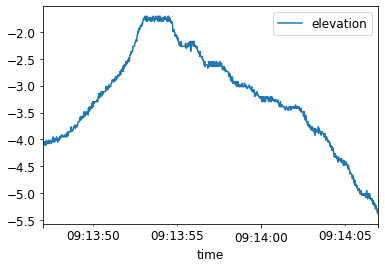

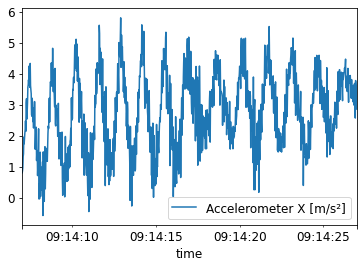

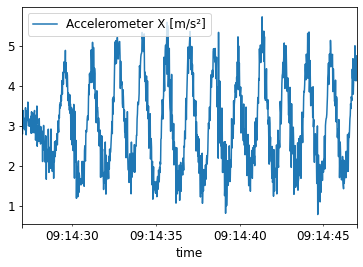

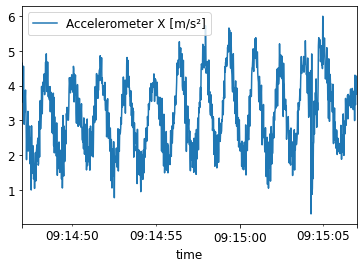

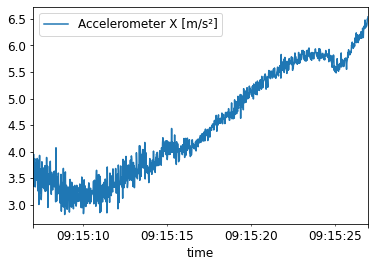

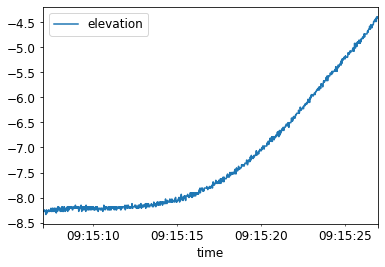

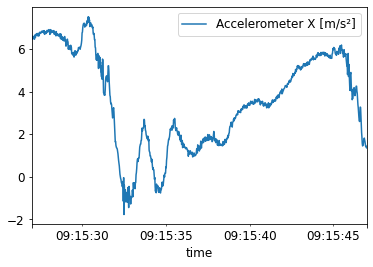

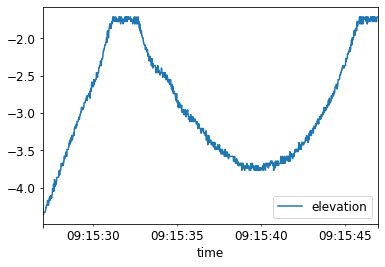

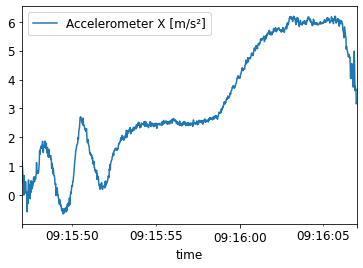

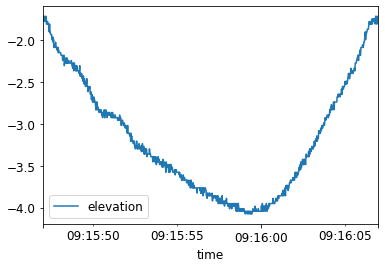

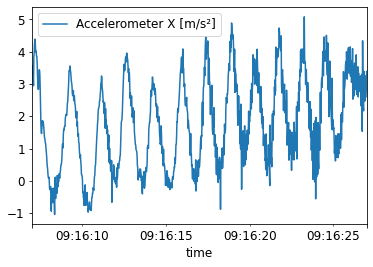

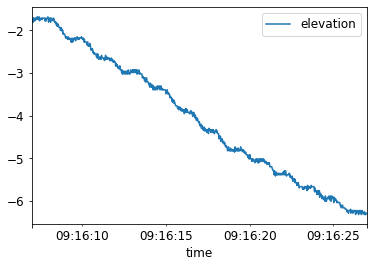

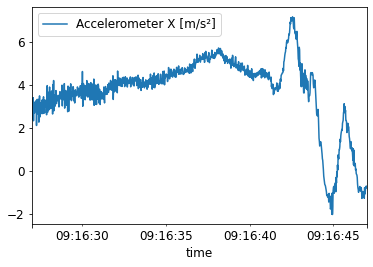

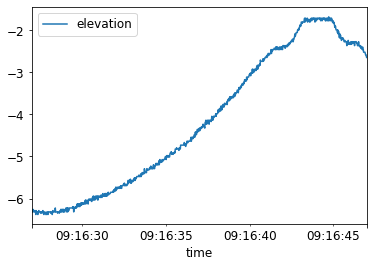

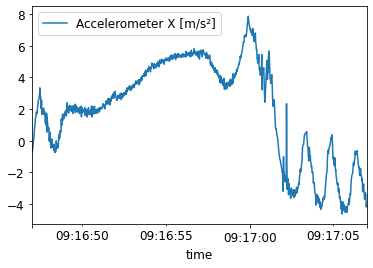

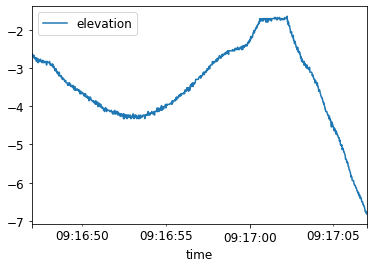

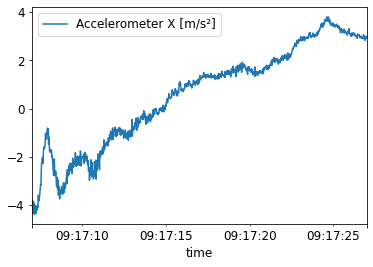

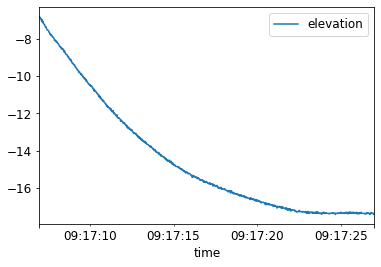

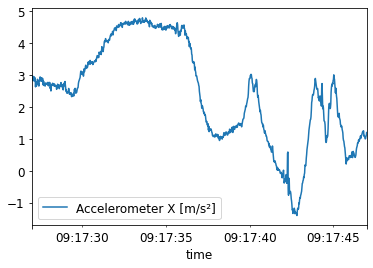

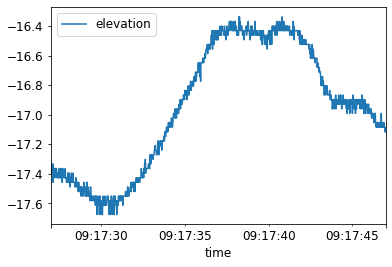

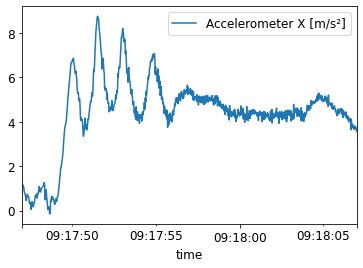

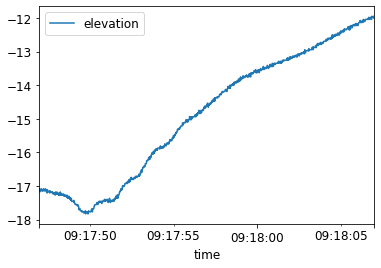

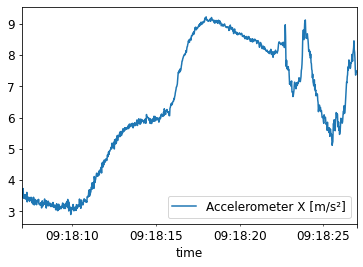

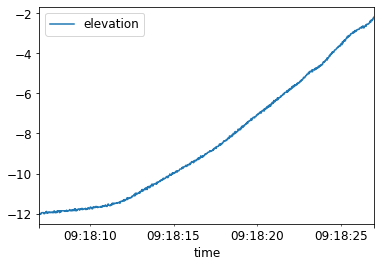

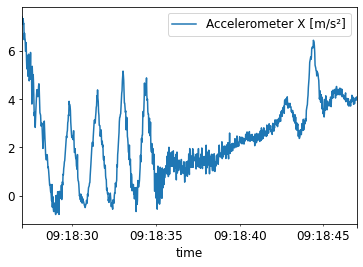

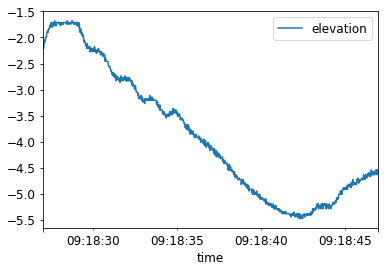

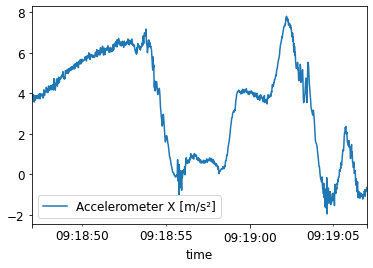

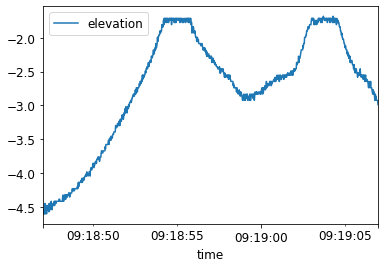

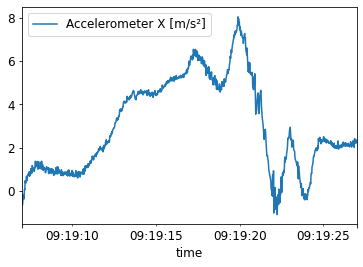

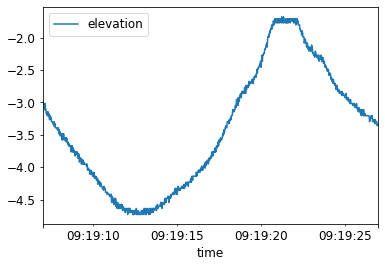

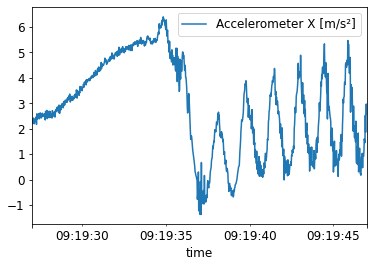

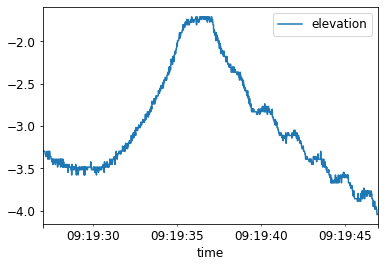

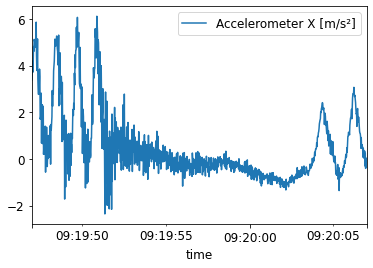

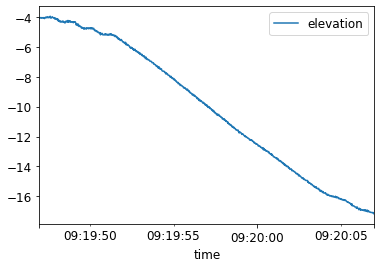

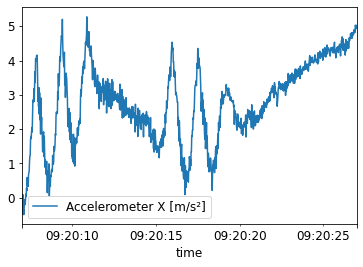

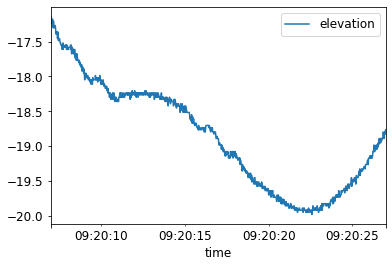

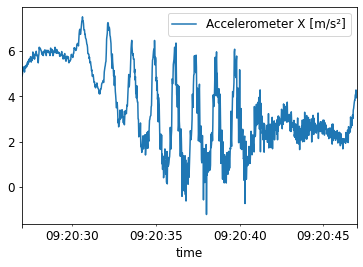

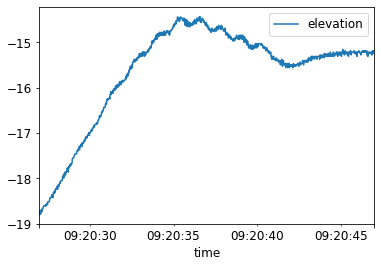

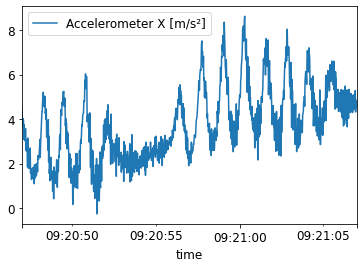

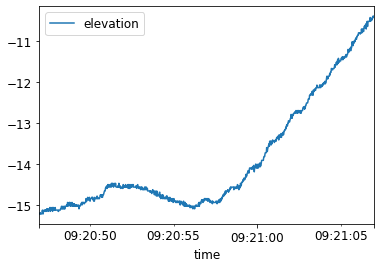

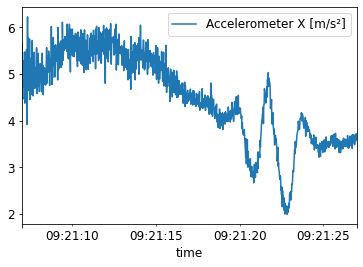

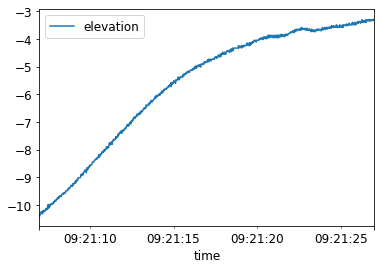

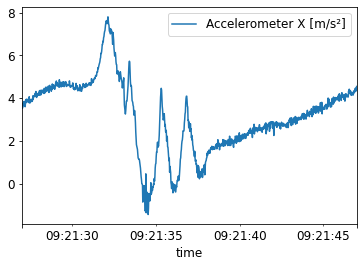

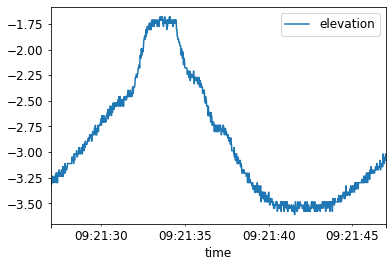

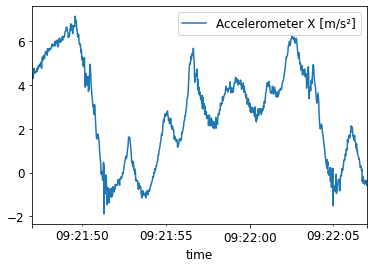

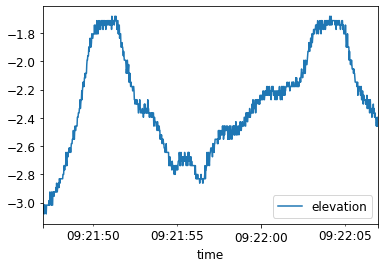

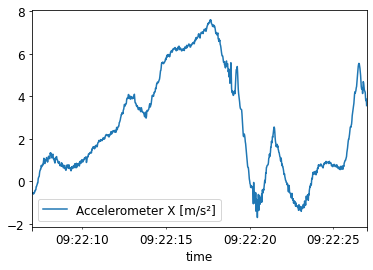

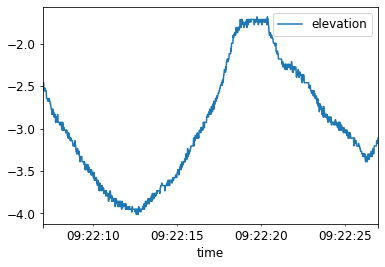

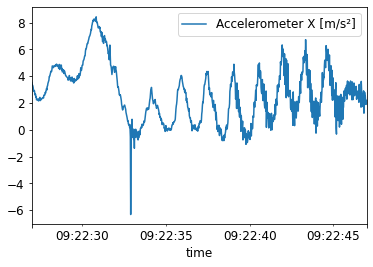

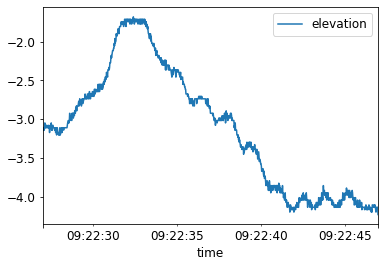

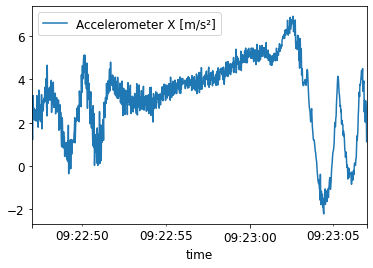

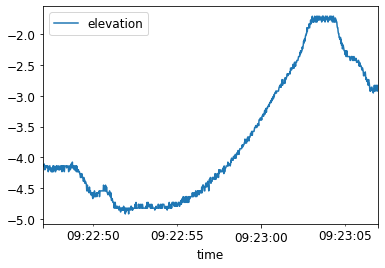

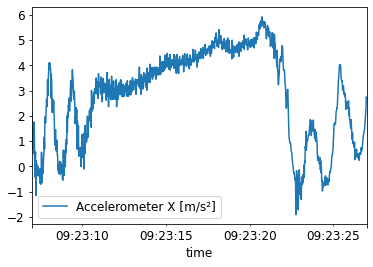

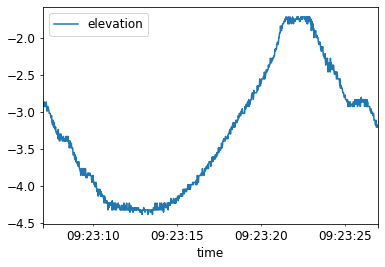

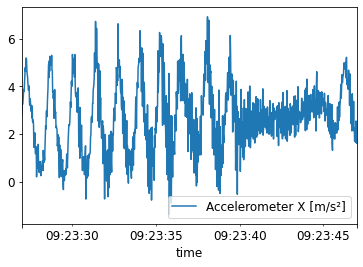

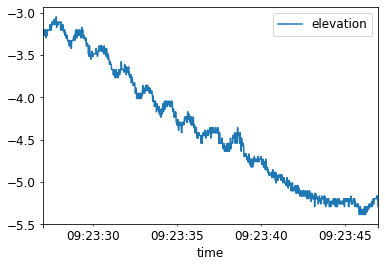

In [52]:
#sind = 153000
#eind = 154000

#df[['time']+ycols].iloc[sind:eind:50].plot('time',ycols[0])
#plt.ylim([15,-1])
#plt.show()

for x in range(100):

    for col in ['Accelerometer X [m/s²]','elevation']:

        try:
            df[['time',col]].iloc[200000+x*(1000):200000+int(x+1.1)*(1000)].plot('time',col)
            if col == 'Accelerometer X [m/s²]':
                print
            plt.show()
        except:
            pass

In [9]:
df[['time',col]].iloc[100000]

time         2020-08-22 08:17:07
elevation               -1.52484
Name: 100000, dtype: object

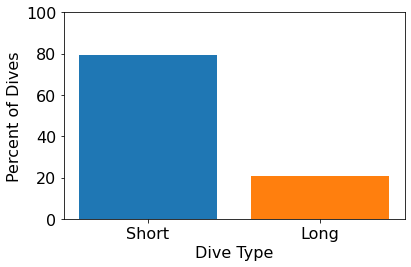

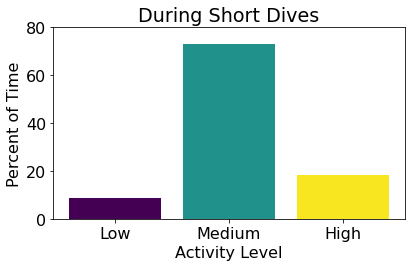

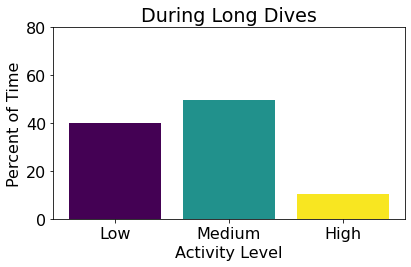

In [28]:
matplotlib.rcParams.update({'font.size': 16})
#matplotlib.rcParams.update({'tick.size': 12})

plt.bar(['Short','Long'],[79.2,20.8],color=[cm.tab10(0),cm.tab10(1)])
plt.xlabel('Dive Type')
plt.ylabel('Percent of Dives')
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('../Plots/coarse-scale-bar.png')
plt.show()

plt.bar(['Low','Medium','High'],[8.7,73.1,18.2],color=[cm.viridis(0),cm.viridis(0.5),cm.viridis(0.99)])
plt.xlabel('Activity Level')
plt.ylabel('Percent of Time')
plt.title('During Short Dives')
plt.ylim([0,80])
plt.tight_layout()
plt.savefig('../Plots/fine-scale-bar-short.png')
plt.show()

plt.bar(['Low','Medium','High'],[40.1,49.6,10.3],color=[cm.viridis(0),cm.viridis(0.5),cm.viridis(0.99)])
plt.xlabel('Activity Level')
plt.ylabel('Percent of Time')
plt.title('During Long Dives')
plt.ylim([0,80])
plt.tight_layout()
plt.savefig('../Plots/fine-scale-bar-long.png')
plt.show()

In [5]:
import matplotlib.cm as cm

In [6]:
cm.tab10(1)

(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)